# 0. Imports

In [61]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

# 1. Generadores

In [62]:
# Generadores
def LCG(seed=None):
    """
    Generador de números pseudoaleatorios usando el método del generador lineal congruencial (LCG).
    """
    a = 16807
    c = 0
    m = (2**31) - 1
    if seed is None:
      seed = int(time.time() * 1000) % m  # Usar tiempo como semilla por defecto
    else:
        seed = seed % m  # Asegurar que la semilla esté en [0, m)

    while True:
        seed = (a * seed + c) % m
        yield seed / m  # Normalizar a [0, 1)

In [63]:
def XORShift(seed=123456789):
    """
    Generador de números pseudoaleatorios usando el método XORShift.
    """
    state = seed & 0xFFFFFFFF
    while True:
        state ^= (state << 13) & 0xFFFFFFFF
        state ^= (state >> 17) & 0xFFFFFFFF
        state ^= (state << 5) & 0xFFFFFFFF
        yield state / 0x100000000

In [64]:
class MT19937:
    def __init__(self, seed):
        """
        Inicializa el estado del generador MT19937 con una semilla.
        """
        self.w = 32  # Tamaño de la palabra
        self.n = 624  # Tamaño del estado
        self.m = 397  # Parámetro de matriz
        self.a = 0x9908B0DF  # Matriz de transformación
        self.u = 11  # Desplazamiento
        self.s = 7  # Parámetro de mezcla
        self.b = 0x9D2C5680  # Parámetro de mezcla
        self.c = 0xEFC60000  # Parámetro de mezcla
        self.t = 15  # Parámetro de mezcla
        self.l = 18  # Parámetro de mezcla
        self.f = 1812433253  # Parámetro de inicialización
        self.UPPER_MASK = 0x80000000  # Máscara superior
        self.LOWER_MASK = 0x7FFFFFFF  # Máscara inferior

        self.mt = [0] * self.n
        self.index = self.n

        self.seed = seed

        # Inicialización del generador con la semilla
        self.mt[0] = seed
        for i in range(1, self.n):
            self.mt[i] = (
                self.f * (self.mt[i - 1] ^ (self.mt[i - 1] >> (self.w - 2))) + i
            ) % 2**self.w

    def twist(self):
        """
        Genera nuevos números aleatorios aplicando la transformación de MT19937.
        """
        for i in range(self.n):
            x = (self.mt[i] & self.UPPER_MASK) + (
                self.mt[(i + 1) % self.n] & self.LOWER_MASK
            )
            xA = x >> 1
            if x % 2 != 0:
                xA ^= self.a
            self.mt[i] = self.mt[(i + self.m) % self.n] ^ xA

        self.index = 0

    def temper(self, y):
        """
        Aplica la transformación de tempering para obtener un número aleatorio.
        """
        y = y ^ (y >> self.u)
        y = y ^ ((y << self.s) & self.b)
        y = y ^ ((y << self.t) & self.c)
        y = y ^ (y >> self.l)
        return y

    def extract_number(self):
        """
        Extrae un número aleatorio del generador.
        """
        while True:
            if self.index >= self.n:
                self.twist()
            y = self.mt[self.index]
            self.index += 1
            yield self.temper(y) / 2**self.w  # Normalizar a [0, 1)


## 1.1 Pruebas de uniformidad (mas que nada pruebas de sanidad)

<ipython-input-65-61571609>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


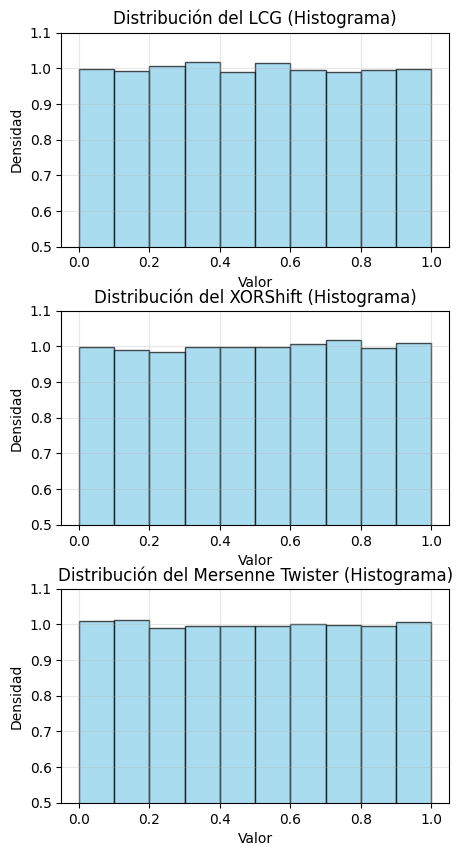

In [65]:
gen1 = LCG(44)
gen2 = XORShift(44)
gen3 = MT19937(44)
Nsim = 100000

# Generar secuencias
numbers1 = [next(gen1) for _ in range(Nsim)]
numbers2 = [next(gen2) for _ in range(Nsim)]
numbers3 = [next(gen3.extract_number()) for _ in range(Nsim)]

# Crear figura con GridSpec
fig = plt.figure(figsize=(5, 10))
gs = GridSpec(3, 1, figure=fig, hspace=0.3)

# Histograma para LCG
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(numbers1, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Distribución del LCG (Histograma)')
ax1.set_xlabel('Valor')
ax1.set_ylabel('Densidad')
ax1.set_ylim(0.5, 1.1)  # Zoom en la parte superior
ax1.grid(alpha=0.3)

# Histograma para XORShift
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(numbers2, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_title('Distribución del XORShift (Histograma)')
ax2.set_xlabel('Valor')
ax2.set_ylabel('Densidad')
ax2.set_ylim(0.5, 1.1)  # Zoom en la parte superior
ax2.grid(alpha=0.3)

# Histograma para Mersenne Twister
ax3 = fig.add_subplot(gs[2, 0])
ax3.hist(numbers3, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7)
ax3.set_title('Distribución del Mersenne Twister (Histograma)')
ax3.set_xlabel('Valor')
ax3.set_ylabel('Densidad')
ax3.set_ylim(0.5, 1.1)  # Zoom en la parte superior
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

<ipython-input-66-1564176709>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


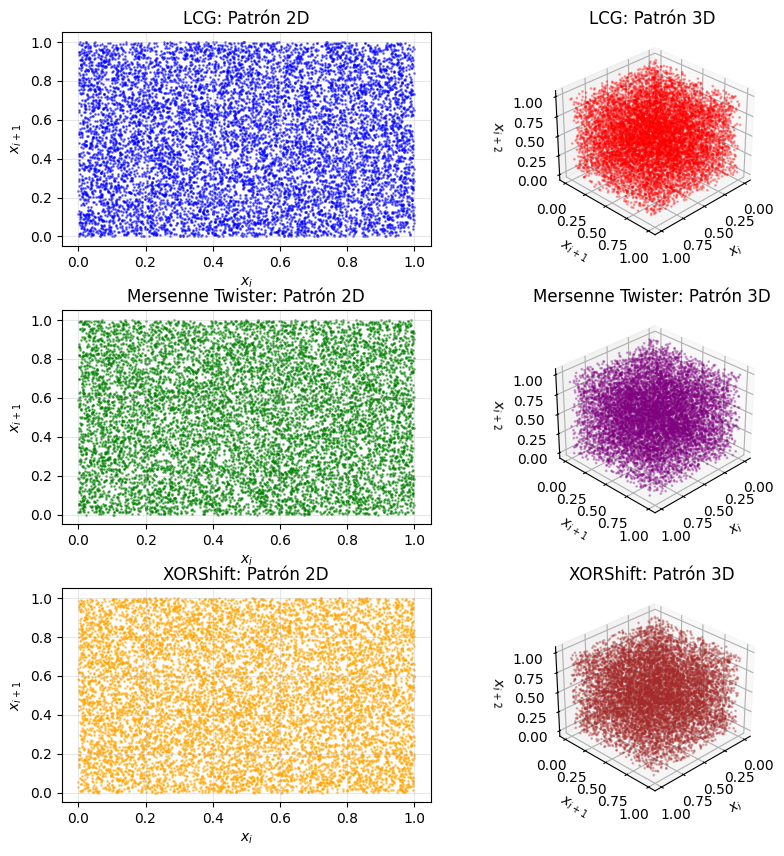

In [66]:
n = 10000

# Generar secuencias
lcg_gen = LCG(42)
lcg_sequence = np.array([next(lcg_gen) for _ in range(n)])

# mt_sequence = np.random.random(n)
mt_gen = MT19937(42)
mt_sequence = np.array([next(mt_gen.extract_number()) for _ in range(n)])

xor_gen = XORShift(42)
xor_sequence = np.array([next(xor_gen) for _ in range(n)])

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(3, 2, figure=fig, wspace=0.1, hspace=0.3)

# 1. LCG - Pares consecutivos
ax = fig.add_subplot(gs[0, 0])
ax.scatter(lcg_sequence[:-1], lcg_sequence[1:], s=1, alpha=0.5, color='blue')
ax.set_title('LCG: Patrón 2D')
ax.set_xlabel('$x_i$')
ax.set_ylabel('$x_{i+1}$')
ax.grid(alpha=0.3)

# 2. LCG - Ternas consecutivas
ax1 = fig.add_subplot(gs[0, 1], projection='3d')
ax1.scatter(lcg_sequence[:-2], lcg_sequence[1:-1], lcg_sequence[2:],
            s=1, alpha=0.3, color='red')
ax1.set_title('LCG: Patrón 3D')
ax1.set_xlabel('$x_i$')
ax1.set_ylabel('$x_{i+1}$')
ax1.set_zlabel('$x_{i+2}$')
ax1.view_init(30, 45)

# 3. Mersenne Twister - Pares consecutivos
ax = fig.add_subplot(gs[1, 0])
ax.scatter(mt_sequence[:-1], mt_sequence[1:], s=1, alpha=0.5, color='green')
ax.set_title('Mersenne Twister: Patrón 2D')
ax.set_xlabel('$x_i$')
ax.set_ylabel('$x_{i+1}$')
ax.grid(alpha=0.3)

# 4. Mersenne Twister - Ternas consecutivas
ax2 = fig.add_subplot(gs[1, 1], projection='3d')
ax2.scatter(mt_sequence[:-2], mt_sequence[1:-1], mt_sequence[2:],
            s=1, alpha=0.3, color='purple')
ax2.set_title('Mersenne Twister: Patrón 3D')
ax2.set_xlabel('$x_i$')
ax2.set_ylabel('$x_{i+1}$')
ax2.set_zlabel('$x_{i+2}$')
ax2.view_init(30, 45)

# 5. XORShift - Pares consecutivos
ax = fig.add_subplot(gs[2, 0])
ax.scatter(xor_sequence[:-1], xor_sequence[1:], s=1, alpha=0.5, color='orange')
ax.set_title('XORShift: Patrón 2D')
ax.set_xlabel('$x_i$')
ax.set_ylabel('$x_{i+1}$')
ax.grid(alpha=0.3)

# 6. XORShift - Ternas consecutivas
ax3 = fig.add_subplot(gs[2, 1], projection='3d')
ax3.scatter(xor_sequence[:-2], xor_sequence[1:-1], xor_sequence[2:],
            s=1, alpha=0.3, color='brown')
ax3.set_title('XORShift: Patrón 3D')
ax3.set_xlabel('$x_i$')
ax3.set_ylabel('$x_{i+1}$')
ax3.set_zlabel('$x_{i+2}$')
ax3.view_init(30, 45)

plt.tight_layout()
#plt.savefig('prueba_uniformidad_generadores.png', dpi=300)
plt.show()

# 2. Preparacion para las simulaciones

## 2.1 Utilidades para data

In [67]:
import numpy as np
class sim_data:
    def __init__(self):
        """
        Clase para guardar los datos de las simulaciones en arreglos.
        Inicializa listas vacías para almacenar los resultados de
        múltiples simulaciones.
        """
        self.n_sims = []
        self.media = []
        self.varianza = []
        self.desvio = []
        self.semiancho = []
        self.ecm = []
        self.tiempo = []


    def add_simulation(self, n_sims, media, varianza, semiancho, tiempo, ecm=None):
        """
        Método para agregar los resultados de una nueva simulación.
        """
        self.n_sims.append(n_sims)
        self.media.append(media)
        self.varianza.append(varianza)
        self.desvio.append(sqrt(varianza))
        self.semiancho.append(semiancho)
        self.ecm.append(ecm)
        self.tiempo.append(tiempo)


def printero(n_sims, media, varianza, semiancho, tiempo, ecm):
    print(f"Numero de simulaciones: {n_sims}\n",
            f"Valor estimado = {media}\n",
            f"Varianza = {varianza}\n",
            f"Desvio estandar = {sqrt(varianza)}\n",
            f"Semiancho del intervalo de confianza de 95% = {semiancho}\n",
            f"ECM = {ecm}\n",
            f"Tiempo = {tiempo}\n"
            )

## 2.2 Monte Carlo de la integral

In [68]:
def f(generador):
    x = [next(generador) for _ in range(5)]  # Generar 5 variables uniformes
    return (sum(x))**2

def montecarlo(f, Nsim, generator, data_storage: sim_data):
    """
    Montecarlo para una integral que usa un generador específico
    para las uniformes.
    Itera hasta alcanzar Nsim o un intervalo de confianza de 95% de
    semiancho 0.001. Almacena los resultados en el objeto data_storage.

    Args:
        f (lambda function): Integrando.
        Nsim (int): Número máximo de simulaciones a realizar.
        generator: Generador que produce números aleatorios en [0, 1)
                   usando yield.
        data_storage (sim_data): Objeto donde se almacenan los resultados
                               de las simulaciones.

    Returns:
        None: Modifica data_storage con los resultados de la simulación.
    """
    start_time = time.time()
    z = norm.ppf(1 - 0.025)  # Para un IC 95%
    media = f(generator)
    ecm = (media-20/3)**2
    SS, n = 0, 1
    while (n < 100  or n < Nsim):
        n += 1
        media_ant = media
        ecm += (media - 20/3)**2
        media = media_ant + (f(generator) - media_ant) / n
        SS = SS * (1 - 1 / (n - 1)) + n * (media - media_ant) ** 2

        #if (not (n % 250000) or n == 2):
            #printero(n, media, SS / (n - 1), z * sqrt(SS / n))
    end_time = time.time()
    tiempo = end_time - start_time

    varianza = SS / (n - 1)
    semiancho = z * sqrt(SS / n)
    data_storage.add_simulation(n, media, varianza, semiancho, tiempo, ecm/n)
    return None


### Pruebas del Monte Carlo

In [69]:
Nsim = 100000

gen_lcg = LCG(44)
lcg_data = sim_data()
# Hacemos montecarlo para el LCG y calculamos cuanto tiempo le lleva
montecarlo(f, Nsim, gen_lcg, lcg_data)
print("LCG" + "-"*100)
printero(lcg_data.n_sims[-1], lcg_data.media[-1], lcg_data.varianza[-1], lcg_data.semiancho[-1], lcg_data.tiempo[0], lcg_data.ecm[-1])

LCG----------------------------------------------------------------------------------------------------
Numero de simulaciones: 100000
 Valor estimado = 6.664929557161925
 Varianza = 0.00010770488867350715
 Desvio estandar = 0.01037809658239444
 Semiancho del intervalo de confianza de 95% = 0.020340593825839418
 ECM = 0.0008240835027043644
 Tiempo = 0.5239663124084473



In [70]:
gen_xor = XORShift(44)
xor_data = sim_data()
# Montecarlo para el XORShift
montecarlo(f, Nsim, gen_xor, xor_data)
print("XORShift" + "-"*100)
printero(xor_data.n_sims[-1], xor_data.media[-1], xor_data.varianza[-1], xor_data.semiancho[-1], xor_data.tiempo[-1], xor_data.ecm[-1])

XORShift----------------------------------------------------------------------------------------------------
Numero de simulaciones: 100000
 Valor estimado = 6.6808739285233845
 Varianza = 0.00010804440048100834
 Desvio estandar = 0.010394440845038676
 Semiancho del intervalo de confianza de 95% = 0.02037262783180475
 ECM = 0.0010540309773789667
 Tiempo = 0.6759772300720215



In [71]:
gen_twister = MT19937(44)
twister_data = sim_data()
# Montecarlo para el Mersenne
montecarlo(f, Nsim, gen_twister.extract_number(), twister_data)
print("Mersenne Twister" + "-"*100)
printero(twister_data.n_sims[-1], twister_data.media[-1], twister_data.varianza[-1], twister_data.semiancho[-1], twister_data.tiempo[-1], twister_data.ecm[-1])

Mersenne Twister----------------------------------------------------------------------------------------------------
Numero de simulaciones: 100000
 Valor estimado = 6.663764857368507
 Varianza = 0.0001071266549100076
 Desvio estandar = 0.010350200718343949
 Semiancho del intervalo de confianza de 95% = 0.020285919210357956
 ECM = 0.0005226176162645892
 Tiempo = 1.2306413650512695



# 3. Simulaciones

## 3.1 Generar datos

In [72]:
# Definir rangos de Nsim para las simulaciones
Nsims = [100, 1000, 10000, 100000]
n_reps = 100
generadores = ['LCG', 'XORShift', 'Mersenne Twister']
valor_real = 20/3

# Crear objetos sim_data para cada generador
lcg_data = sim_data()
xor_data = sim_data()
twister_data = sim_data()

lcg_data_final = sim_data()
xor_data_final = sim_data()
twister_data_final = sim_data()

gen_lcg = LCG(44)
gen_xor = XORShift(44)
gen_twister = MT19937(44).extract_number()

# Simulaciones
for Nsim in Nsims:
    # Reiniciar datos para cada Nsim
    lcg_data.media.clear()
    lcg_data.varianza.clear()
    lcg_data.semiancho.clear()
    lcg_data.n_sims.clear()
    lcg_data.tiempo.clear()
    lcg_data.ecm.clear()
    xor_data.media.clear()
    xor_data.varianza.clear()
    xor_data.semiancho.clear()
    xor_data.n_sims.clear()
    xor_data.tiempo.clear()
    xor_data.ecm.clear()
    twister_data.media.clear()
    twister_data.varianza.clear()
    twister_data.semiancho.clear()
    twister_data.n_sims.clear()
    twister_data.tiempo.clear()
    twister_data.ecm.clear()



    # Para cada Nsim hago n_reps repeticiones
    for _ in range(n_reps):
        montecarlo(f, Nsim, gen_lcg, lcg_data)
        montecarlo(f, Nsim, gen_xor, xor_data)
        montecarlo(f, Nsim, gen_twister, twister_data)

    # Agregar promedio de datos de cada Nsim
    lcg_data_final.add_simulation(np.mean(lcg_data.n_sims),
                                 np.mean(lcg_data.media),
                                 np.mean(lcg_data.varianza),
                                 np.mean(lcg_data.semiancho),
                                 np.mean(lcg_data.tiempo),
                                 np.mean(lcg_data.ecm))
    xor_data_final.add_simulation(np.mean(xor_data.n_sims),
                                 np.mean(xor_data.media),
                                 np.mean(xor_data.varianza),
                                 np.mean(xor_data.semiancho),
                                 np.mean(xor_data.tiempo),
                                 np.mean(xor_data.ecm))

    twister_data_final.add_simulation(np.mean(twister_data.n_sims),
                                     np.mean(twister_data.media),
                                     np.mean(twister_data.varianza),
                                     np.mean(twister_data.semiancho),
                                     np.mean(twister_data.tiempo),
                                     np.mean(twister_data.ecm))

# Imprimir resultados
data_finals = [lcg_data_final, xor_data_final, twister_data_final]
for j in range(len(Nsims)):
    print(f"Nsim={Nsims[j]}"+"-"*100)
    for i, gen in enumerate(generadores):
        print(f"{gen}"+"-"*100)
        print(f"Nsim={Nsims[j]}: Media={data_finals[i].media[j]}")
        print(f"Varianza={data_finals[i].varianza[j]}, Semiancho={data_finals[i].semiancho[j]}, ECM={data_finals[i].ecm[j]}, Tiempo={data_finals[i].tiempo[j]}")
    print()

Nsim=100----------------------------------------------------------------------------------------------------
LCG----------------------------------------------------------------------------------------------------
Nsim=100: Media=6.686751887403784
Varianza=0.10682083656606008, Semiancho=0.6356749520926174, ECM=0.7184478022063403, Tiempo=0.0004590964317321777
XORShift----------------------------------------------------------------------------------------------------
Nsim=100: Media=6.722394616086173
Varianza=0.1112628696311482, Semiancho=0.648222458870015, ECM=0.6437730237442741, Tiempo=0.0005332112312316894
Mersenne Twister----------------------------------------------------------------------------------------------------
Nsim=100: Media=6.654132749467882
Varianza=0.10772641533243134, Semiancho=0.6372858355866218, ECM=0.6387597171831514, Tiempo=0.0009993815422058106

Nsim=1000----------------------------------------------------------------------------------------------------
LCG--------

## 3.2 Generar Graficos

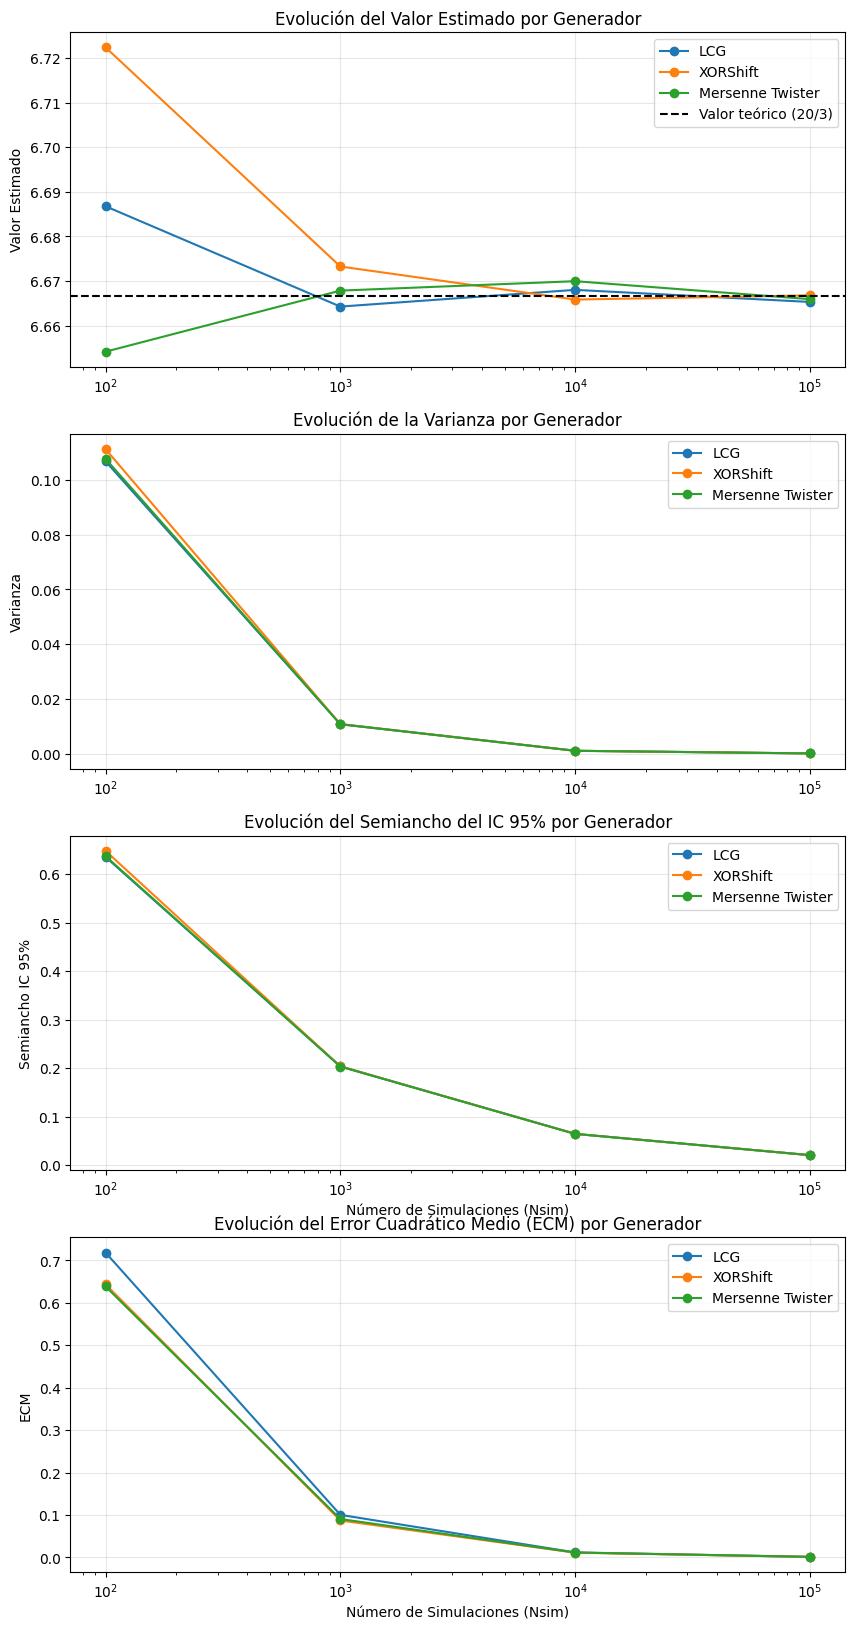

In [73]:
# Crear figura con subgráficos
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 20))

# Graficar medias
for i, data_final in enumerate(data_finals):
    ax1.plot(Nsims, data_final.media, marker='o', label=generadores[i])
ax1.axhline(y=valor_real, color='k', linestyle='--', label='Valor teórico (20/3)')
ax1.set_ylabel('Valor Estimado')
ax1.set_title('Evolución del Valor Estimado por Generador')
ax1.legend()
ax1.grid(alpha=0.3)

# Graficar varianzas
for i, data_final in enumerate(data_finals):
    ax2.plot(Nsims, data_final.varianza, marker='o', label=generadores[i])
ax2.set_ylabel('Varianza')
ax2.set_title('Evolución de la Varianza por Generador')
ax2.legend()
ax2.grid(alpha=0.3)

# Graficar semianchos
for i, data_final in enumerate(data_finals):
    ax3.plot(Nsims, data_final.semiancho, marker='o', label=generadores[i])
ax3.set_xlabel('Número de Simulaciones (Nsim)')
ax3.set_ylabel('Semiancho IC 95%')
ax3.set_title('Evolución del Semiancho del IC 95% por Generador')
ax3.legend()
ax3.grid(alpha=0.3)

# Graficar ECM
for i, data_final in enumerate(data_finals):
    ax4.plot(Nsims, data_final.ecm, marker='o', label=generadores[i])
ax4.set_xlabel('Número de Simulaciones (Nsim)')
ax4.set_ylabel('ECM')
ax4.set_title('Evolución del Error Cuadrático Medio (ECM) por Generador')
ax4.legend()
ax4.grid(alpha=0.3)

# Configurar escala logarítmica en el eje x
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xscale('log')
    ax.set_xticks(Nsims)
    ax.set_xticklabels([f'$10^{int(np.log10(n))}$' for n in Nsims])